# 词嵌入的可视化（Visualization of Embedding）

### 加载所需python库

In [1]:
# pip install torch transformers scikit-learn matplotlib
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

### 1.加载GPT-2的tokenizer和模型embedding参数

In [2]:
model_name = "gpt2" 
tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval()
emb = model.get_input_embeddings().weight  # [vocab_size, hidden_size]
print(f"\n嵌入矩阵维度：{emb.T.shape}")


嵌入矩阵维度：torch.Size([768, 50257])


In [3]:
# 提取词表（字典：token -> id）
vocab_dict = tok.get_vocab()  # {'<|endoftext|>': 50256, '!', 0, ...}
# 转成 DataFrame 并排序
df = pd.DataFrame(list(vocab_dict.items()), columns=["token", "id"]).sort_values("id")
# 保存为 CSV
df["token_clean"] = df["token"].str.replace("Ġ", " ", regex=False)
df.to_csv("gpt2_vocab.csv", index=False, encoding="utf-8-sig")

### 2. 准备文本

In [4]:
Words = [
    "car", "bus", "van", "bike", "train", "plane", "ship", "tube",
    "China", "France", "Japan", "Brazil", "Canada", "Germany", "Italy", "India",
    "red", "orange", "yellow", "green", "blue", "black", "white", "gray"
]

### 3.取每个token的embedding向量

In [5]:
vecs = []
with torch.no_grad():
    for word in Words:
        # 用 tokenizer 得到 token id 序列
        tokens = tok(word, add_special_tokens=False)["input_ids"]
        print(f"{word:15s} → token IDs: {tokens}") 
        # 若单词对应多个Token，则取第一个 token 的 id
        token_id = tokens[0]
        # 从 embedding 矩阵中索引该行向量
        token_vector = emb[token_id]  # shape [hidden_size]
        # 保存到列表中
        vecs.append(token_vector.cpu().numpy())
        
# 转成 numpy 数组
X = np.stack(vecs)
print(f"\nX的嵌入维度：{X.T.shape}")

car             → token IDs: [7718]
bus             → token IDs: [10885]
van             → token IDs: [10438]
bike            → token IDs: [32256]
train           → token IDs: [27432]
plane           → token IDs: [14382]
ship            → token IDs: [6720]
tube            → token IDs: [29302]
China           → token IDs: [14581]
France          → token IDs: [28572]
Japan           → token IDs: [16504]
Brazil          → token IDs: [39190]
Canada          → token IDs: [17940]
Germany         → token IDs: [27079]
Italy           → token IDs: [45001]
India           → token IDs: [21569]
red             → token IDs: [445]
orange          → token IDs: [43745]
yellow          → token IDs: [36022]
green           → token IDs: [14809]
blue            → token IDs: [17585]
black           → token IDs: [13424]
white           → token IDs: [11186]
gray            → token IDs: [44605]

X的嵌入维度：(768, 24)


### 4.降维与可视化

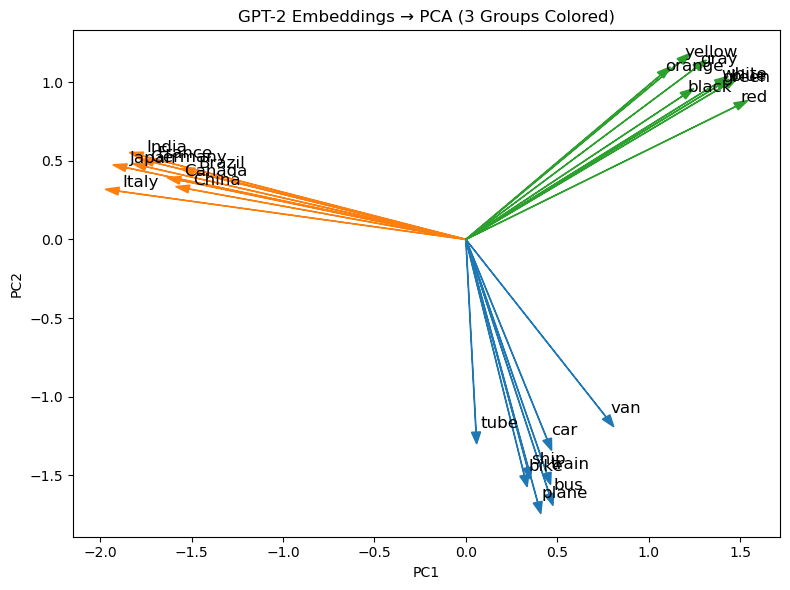

In [6]:
# 主成分分析（PCA）降维
X2 = PCA(n_components=2, random_state=42).fit_transform(X)

# 可视化
plt.figure(figsize=(8,6))
colors = ['tab:blue']*8 + ['tab:orange']*8 + ['tab:green']*8
# plt.scatter(X2[:,0], X2[:,1], c=colors, s=60)
for i, w in enumerate(Words):
    plt.annotate(w, (X2[i,0], X2[i,1]), fontsize=12, xytext=(3,3), textcoords='offset points')
    plt.arrow(0, 0, X2[i,0], X2[i,1], color=colors[i], width=0.002, head_width=0.05)

plt.title("GPT-2 Embeddings → PCA (3 Groups Colored)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()